# 信用卡詐欺檢測系統

## 專案概述
本專案旨在建立機器學習模型來偵測信用卡詐欺交易。使用包含真實信用卡交易數據的資料集，我們將應用資料處理、特徵工程、模型訓練和評估技術來識別潛在的詐欺活動。

## 主要挑戰
- 處理嚴重不平衡的資料集（詐欺交易通常不到1%）
- 優化模型以平衡精確率和召回率
- 評估模型在實際應用場景中的有效性

In [6]:
# 導入必要的庫
# 標準函式庫
import os
import datetime

# 第三方函式庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn 相關
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# 處理不平衡資料
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# 模型持久化
import pickle

# 專案特定
import kagglehub

# 設定固定參數 (請勿修改)
RANDOM_SEED = 42
TEST_SIZE = 0.3

# 設定視覺化風格
sns.set_style('whitegrid')
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

## 資料載入與探索

接下來我們將：
1. 從 KaggleHub 下載信用卡詐欺資料集
2. 檢查資料集的基本資訊（大小、欄位等）
3. 分析目標變數的分佈（詐欺與非詐欺交易比例）
4. 視覺化呈現資料的特性

In [7]:
# 從KaggleHub下載資料集
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")

# 顯示資料集基本資訊
print(f"Dataset dimension: {data.shape}")
print("\nDataset information:")
print(data.info())

# 顯示資料集統計資訊
print("\nBasic statistics:")
print(data.describe())

# 檢查目標變數分布
fraud_count = data['Class'].value_counts()
print("\nClass distribution:")
print(f"Normal transactions (Class=0): {fraud_count[0]} ({fraud_count[0]/len(data)*100:.4f}%)")
print(f"Fraud transactions (Class=1): {fraud_count[1]} ({fraud_count[1]/len(data)*100:.4f}%)")

# 檢查缺失值
missing_values = data.isnull().sum()
print("\nMissing values count:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Dataset dimension: (284807, 31)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64

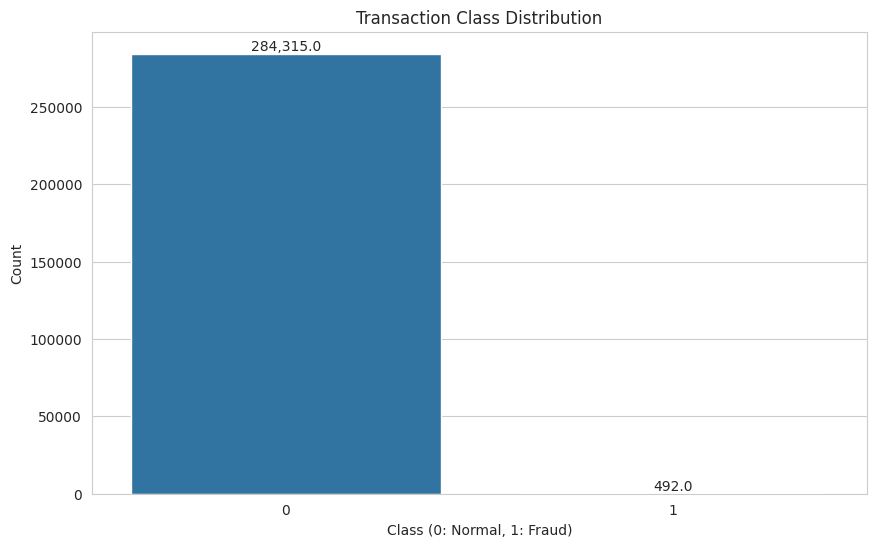

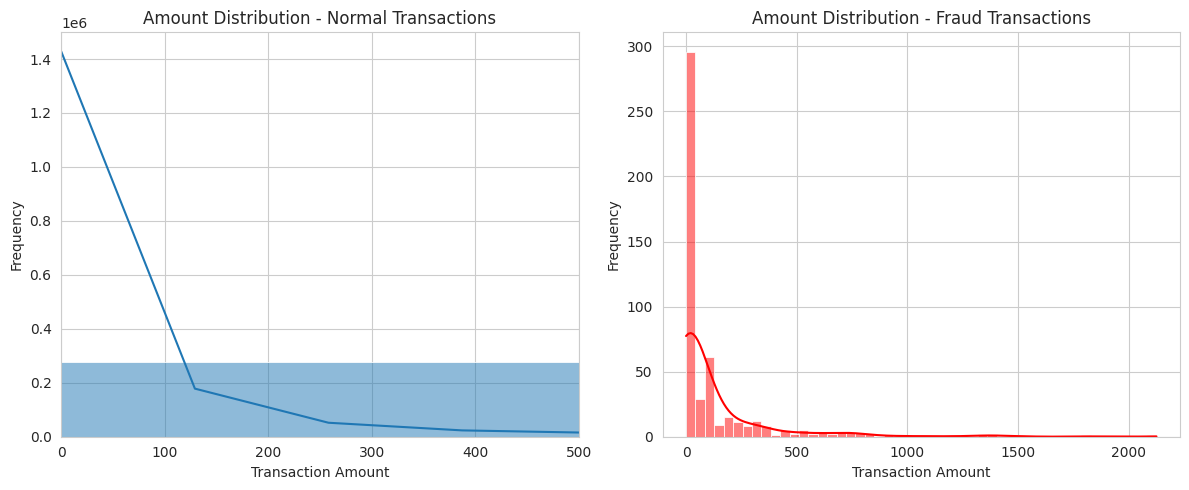

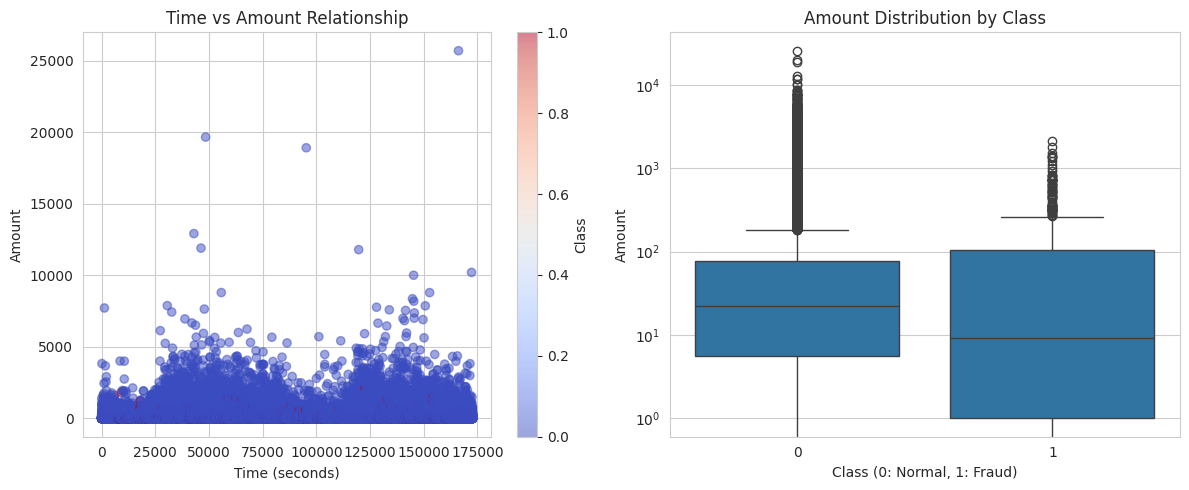

In [8]:
# 視覺化類別分布
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', data=data)
plt.title('Transaction Class Distribution')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')

# 在柱狀圖上顯示具體數值
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

# 視覺化詐欺與非詐欺交易的金額分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data[data['Class'] == 0]['Amount'], bins=50, kde=True)
plt.title('Amount Distribution - Normal Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xlim([0, 500])  # 聚焦於大部分資料範圍

plt.subplot(1, 2, 2)
sns.histplot(data[data['Class'] == 1]['Amount'], bins=50, kde=True, color='red')
plt.title('Amount Distribution - Fraud Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 顯示Time和Amount與目標變數的關係
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(data['Time'], data['Amount'], c=data['Class'], alpha=0.5, cmap='coolwarm')
plt.colorbar(label='Class')
plt.title('Time vs Amount Relationship')
plt.xlabel('Time (seconds)')
plt.ylabel('Amount')

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Amount Distribution by Class')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Amount')
plt.yscale('log')  # 使用對數尺度顯示

plt.tight_layout()
plt.show()

## 資料預處理

在這個部分，我們將進行以下操作：
1. 分離特徵與目標變數
2. 特徵標準化處理（包括 Time 和 Amount 欄位）
3. 資料分割為訓練集和測試集
4. 處理資料不平衡問題（使用 SMOTE 或其他技術）

In [9]:
# 資料預處理函數
def preprocess_data(data, test_size=TEST_SIZE, random_state=RANDOM_SEED):
    """執行資料預處理步驟"""
    # 分離特徵和目標變數
    X = data.drop('Class', axis=1)
    y = data['Class']

    # 特徵標準化處理
    scaler = StandardScaler()

    # 特別處理 Time 和 Amount 欄位
    X_scaled = X.copy()
    X_scaled['Time'] = scaler.fit_transform(X[['Time']])
    X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])

    # 資料分割
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Training set class distribution: \n{pd.Series(y_train).value_counts()}")
    print(f"Test set class distribution: \n{pd.Series(y_test).value_counts()}")

    return X_train, X_test, y_train, y_test, scaler

# 執行資料預處理
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

# 處理訓練集中的不平衡問題
def handle_imbalance(X_train, y_train, method='smote', random_state=RANDOM_SEED):
    """使用不同方法處理不平衡資料"""
    if method == 'smote':
        resampler = SMOTE(random_state=random_state)
    elif method == 'adasyn':
        resampler = ADASYN(random_state=random_state)
    elif method == 'undersampling':
        resampler = RandomUnderSampler(random_state=random_state)
    elif method == 'smote_tomek':
        resampler = SMOTETomek(random_state=random_state)
    elif method == 'smote_enn':
        resampler = SMOTEENN(random_state=random_state)
    else:
        # 若未指定有效方法，預設使用SMOTE
        resampler = SMOTE(random_state=random_state)

    # 執行重採樣
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    print(f"Class distribution before resampling: \n{pd.Series(y_train).value_counts()}")
    print(f"Class distribution after resampling: \n{pd.Series(y_resampled).value_counts()}")

    return X_resampled, y_resampled

# 使用SMOTE處理訓練集不平衡問題
X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train, method='smote')

Training set size: (199364, 30)
Test set size: (85443, 30)
Training set class distribution: 
Class
0    199020
1       344
Name: count, dtype: int64
Test set class distribution: 
Class
0    85295
1      148
Name: count, dtype: int64
Class distribution before resampling: 
Class
0    199020
1       344
Name: count, dtype: int64
Class distribution after resampling: 
Class
0    199020
1    199020
Name: count, dtype: int64


## 模型訓練與評估

在這個部分，我們將：
1. 訓練隨機森林分類器模型
2. 使用訓練好的模型進行預測
3. 計算各種評估指標（準確率、精確率、召回率、F1分數、ROC AUC等）
4. 繪製混淆矩陣以視覺化模型表現

In [10]:
# 定義模型訓練和評估函數
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='random_forest', class_weight=None):
    """訓練模型並進行評估"""
    # 模型選擇
    if model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            random_state=RANDOM_SEED,
            class_weight=class_weight
        )
    # 可以添加其他模型類型...

    # 訓練模型
    print(f"Start training {model_type} model...")
    model.fit(X_train, y_train)
    print("Model training completed")

    # 預測
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 計算評估指標
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

    # 打印評估結果
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # 詳細分類報告
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model, metrics, y_pred, y_prob

# 使用原始不平衡數據訓練模型（baseline）
print("=== Training Model with Original Imbalanced Data ===")
baseline_model, baseline_metrics, baseline_y_pred, baseline_y_prob = train_and_evaluate_model(
    X_train, y_train, X_test, y_test
)

# 使用平衡後的數據訓練模型
print("\n=== Training Model with SMOTE Balanced Data ===")
balanced_model, balanced_metrics, balanced_y_pred, balanced_y_prob = train_and_evaluate_model(
    X_train_resampled, y_train_resampled, X_test, y_test
)

# 使用class_weight參數訓練模型
print("\n=== Training Model with Class Weight Parameter ===")
weighted_model, weighted_metrics, weighted_y_pred, weighted_y_prob = train_and_evaluate_model(
    X_train, y_train, X_test, y_test, class_weight='balanced'
)

=== Training Model with Original Imbalanced Data ===
Start training random_forest model...
Model training completed

Model Evaluation Results:
Accuracy: 0.9994
Precision: 0.9174
Recall: 0.7500
F1-score: 0.8253
ROC AUC Score: 0.9649

Confusion Matrix:
[[85285    10]
 [   37   111]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.75      0.83       148

    accuracy                           1.00     85443
   macro avg       0.96      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443


=== Training Model with SMOTE Balanced Data ===
Start training random_forest model...
Model training completed

Model Evaluation Results:
Accuracy: 0.9981
Precision: 0.4764
Recall: 0.8176
F1-score: 0.6020
ROC AUC Score: 0.9727

Confusion Matrix:
[[85162   133]
 [   27   121]]

Classification Report:
              precision    recall  f1-score   support

          

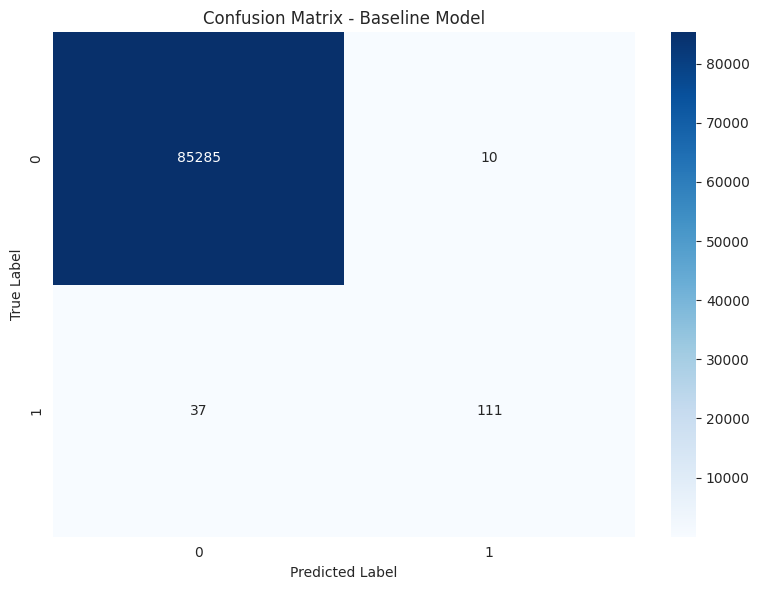

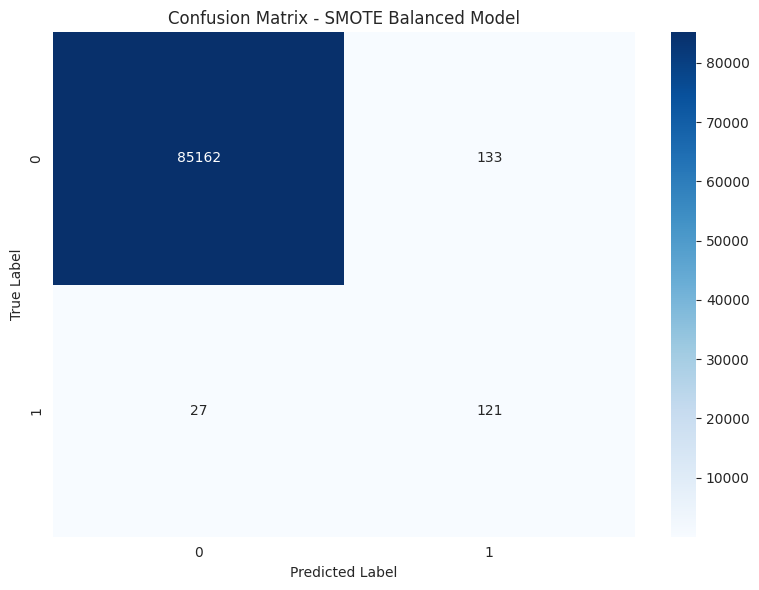

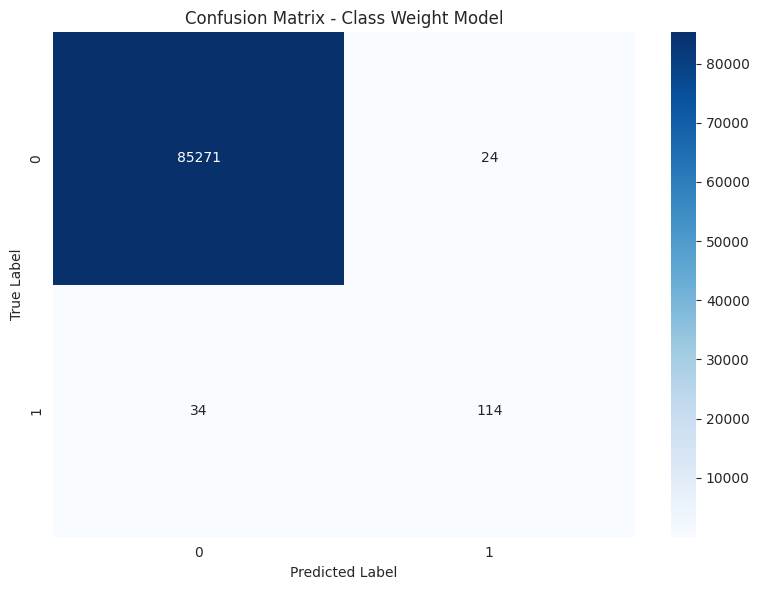

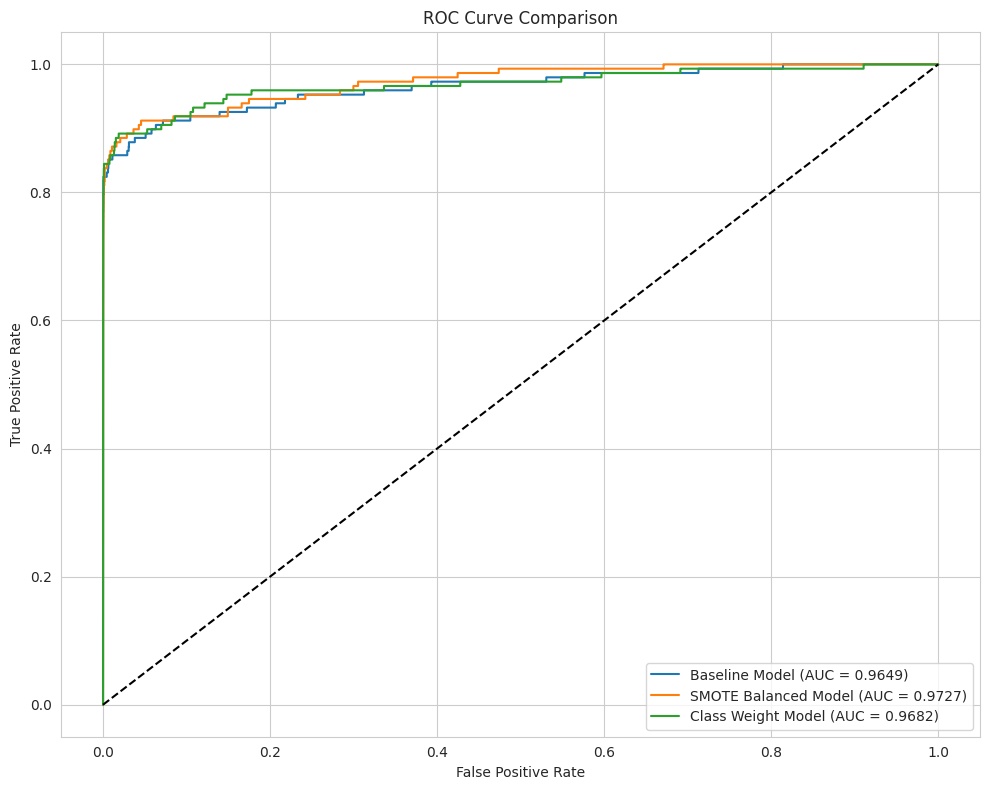

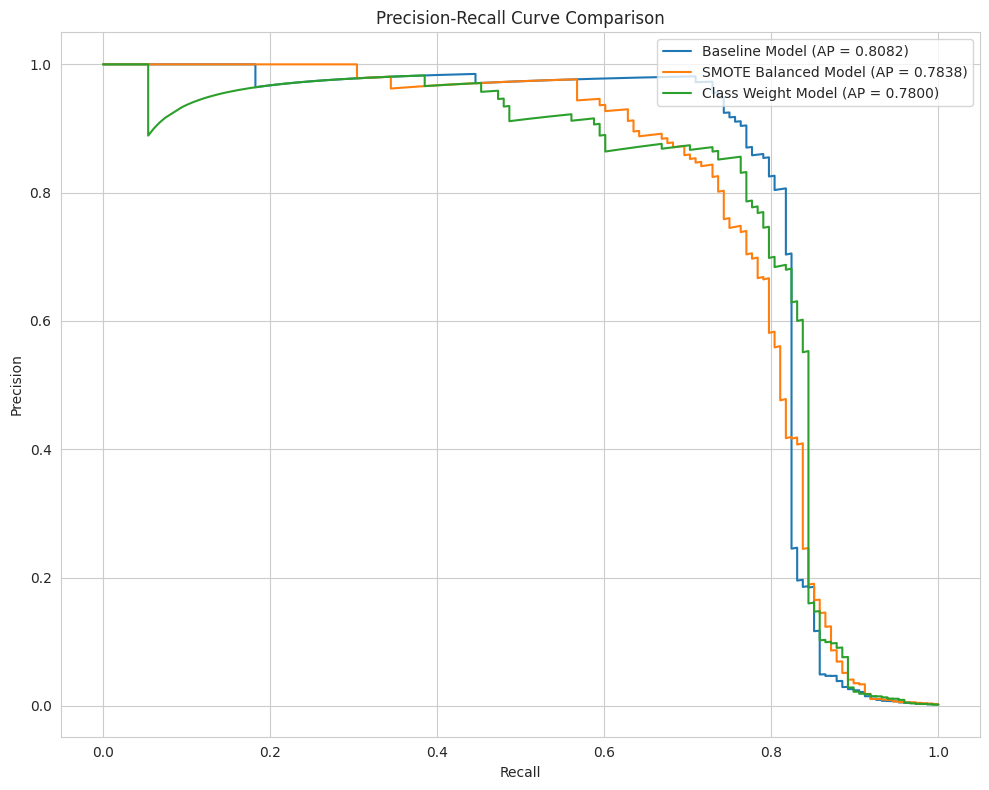

<Figure size 1200x800 with 0 Axes>

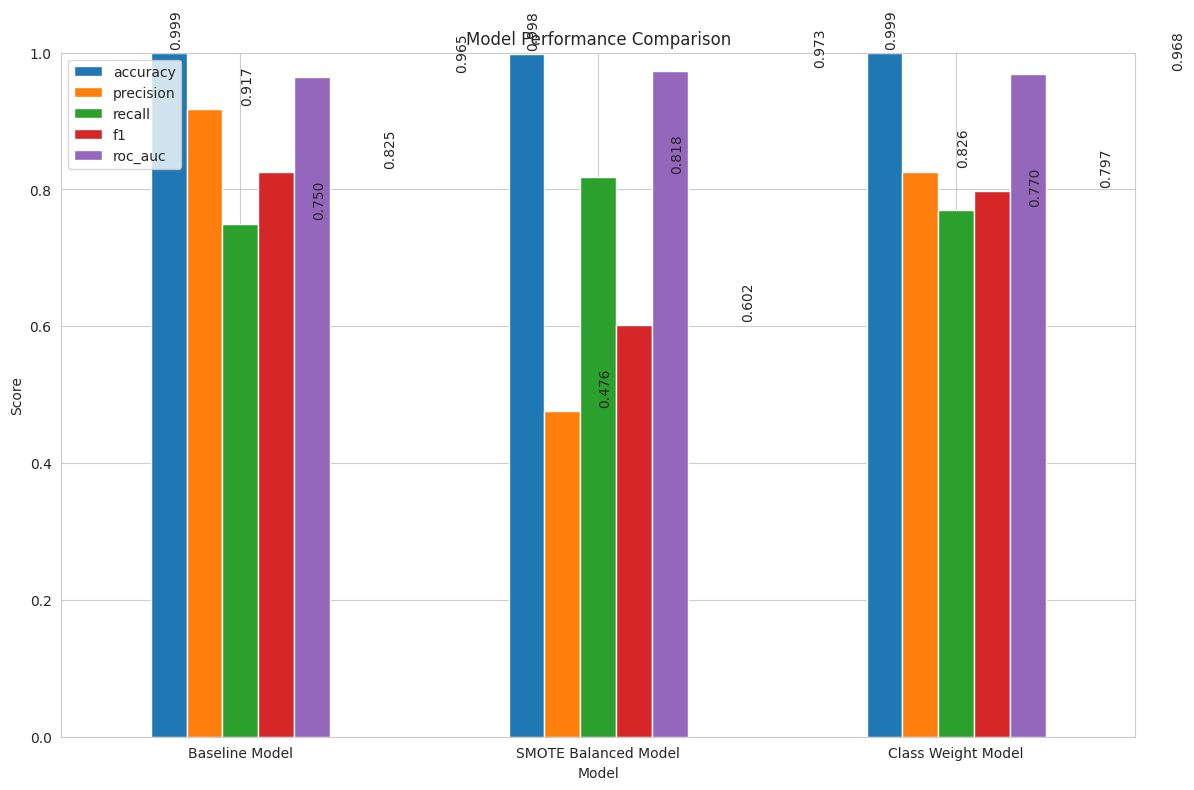

In [11]:
# 視覺化評估結果
def plot_confusion_matrix(y_test, y_pred, title):
    """繪製混淆矩陣"""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# 繪製ROC曲線
def plot_roc_curve(y_test, y_probs_dict, title):
    """繪製多個模型的ROC曲線"""
    from sklearn.metrics import roc_curve

    plt.figure(figsize=(10, 8))

    for name, y_prob in y_probs_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')  # 對角線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 繪製精確率-召回率曲線
def plot_precision_recall_curve(y_test, y_probs_dict, title):
    """繪製多個模型的精確率-召回率曲線"""
    from sklearn.metrics import precision_recall_curve, average_precision_score

    plt.figure(figsize=(10, 8))

    for name, y_prob in y_probs_dict.items():
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 視覺化比較不同模型的性能
def plot_model_comparison(metrics_dict, title):
    """比較不同模型的性能指標"""
    metrics_df = pd.DataFrame(metrics_dict).T

    plt.figure(figsize=(12, 8))
    metrics_df.plot(kind='bar', figsize=(12, 8))
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y')
    plt.ylim(0, 1)

    # 在柱狀圖上顯示數值
    for i, row in enumerate(metrics_df.iterrows()):
        for j, value in enumerate(row[1]):
            plt.text(i - 0.2 + j*0.2, value + 0.01, f'{value:.3f}', rotation=90)

    plt.tight_layout()
    plt.show()

# 繪製混淆矩陣
plot_confusion_matrix(y_test, baseline_y_pred, 'Confusion Matrix - Baseline Model')
plot_confusion_matrix(y_test, balanced_y_pred, 'Confusion Matrix - SMOTE Balanced Model')
plot_confusion_matrix(y_test, weighted_y_pred, 'Confusion Matrix - Class Weight Model')

# 繪製ROC曲線
y_probs_dict = {
    'Baseline Model': baseline_y_prob,
    'SMOTE Balanced Model': balanced_y_prob,
    'Class Weight Model': weighted_y_prob
}
plot_roc_curve(y_test, y_probs_dict, 'ROC Curve Comparison')

# 繪製精確率-召回率曲線
plot_precision_recall_curve(y_test, y_probs_dict, 'Precision-Recall Curve Comparison')

# 比較不同模型的性能指標
metrics_dict = {
    'Baseline Model': baseline_metrics,
    'SMOTE Balanced Model': balanced_metrics,
    'Class Weight Model': weighted_metrics
}
plot_model_comparison(metrics_dict, 'Model Performance Comparison')